In [1]:
import requests
import io
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import numpy as np

# To parse PDFs
from PyPDF2 import PdfFileReader

# Plots
import matplotlib.pyplot as plt

# Statistics
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
base_url = 'https://www.who.int'
url = 'https://www.who.int/emergencies/diseases/novel-coronavirus-2019/situation-reports/'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'lxml')

In [3]:
tempList = []
for element in soup.find_all('a', href=True):
    if 'situation-reports' in str(element):
        tempList.append(str(element))
        
pdfurls = []

lastreport = None

for url in tempList:
    x = url.replace('<a href="', '')
    index = x.find('?')
    extraction = x[0:index]
    reportnumber = extraction[68:70]
    
    if reportnumber != lastreport:
        pdfurls.append(base_url + extraction)
        
    lastreport = extraction[68:70]

In [4]:
# Solution 1
sample = pdfurls[0]
r = requests.get(sample)
f = io.BytesIO(r.content)
reader = PdfFileReader(f)
contents = reader.getPage(0).extractText().split('\n')

# Find the Netherlands
try:
    contents.index('Netherlands')
except:
    pass

In [5]:
total_confirmed_cases = []
total_confirmed_new_cases = []
total_confirmed_total_deaths = []
total_confirmed_total_new_death = []

for pdf in pdfurls:
    
    r = requests.get(pdf)
    f = io.BytesIO(r.content)
    reader = PdfFileReader(f)
    
    for page in range(reader.getNumPages()):
        try:
            page_content = reader.getPage(page).extractText().split('\n')
            page_index = (page_content.index('Netherlands'))
            
            total_confirmed_cases.append(page_content[page_index+2])
            total_confirmed_new_cases.append(page_content[page_index+4])
            total_confirmed_total_deaths.append(page_content[page_index+6])
            total_confirmed_total_new_death.append(page_content[page_index+8])
        
        except:
            pass

In [6]:
df = pd.DataFrame(data=[
                  total_confirmed_cases,
                  total_confirmed_new_cases,
                  total_confirmed_total_deaths,
                  total_confirmed_total_new_death]).transpose()

In [7]:
df.columns = ['Cumulative confirmed', 'New confirmed', 'Cumulative deaths', 'New deaths']

In [8]:
plot_data = df.loc[0:len(df.index)-4]
plot_data = plot_data.replace(r'^\s*$', 0, regex=True)
plot_data = plot_data.astype(int)
plot_data = plot_data.sort_index(ascending=False).reset_index()
plot_data = plot_data.iloc[:,1:]

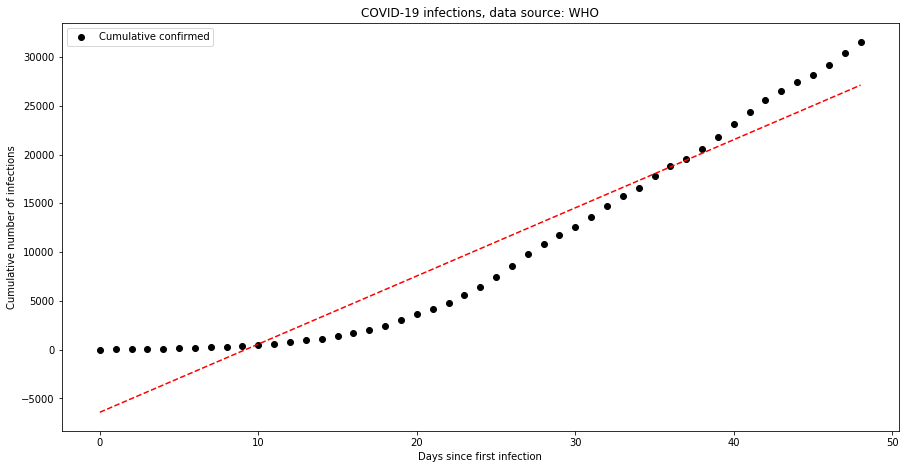

In [9]:
fig, ax = plt.subplots(figsize=(15, 7.5))

plt.title('COVID-19 infections, data source: WHO', size=12)
plt.xlabel('Days since first infection')
plt.ylabel('Cumulative number of infections')

x = plot_data.index
y = plot_data['Cumulative confirmed']

# Scatter plot
plt.scatter(x, y, color='black')

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.legend()

plt.savefig('infections_plot.png', dpi=300, bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7.5))

plt.title('COVID-19 deaths, data source: WHO', size=12)
plt.xlabel('Days since first infection')
plt.ylabel('Cumulative number of deaths')

x = plot_data.index
y = plot_data['Cumulative deaths']

# Scatter plot
plt.scatter(x, y, color='black')

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.legend()

plt.savefig('deaths_plot.png', dpi=300, bbox_inches='tight');

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7.5))

plt.title('COVID-19 infections and deaths, data source: WHO', size=12)
plt.xlabel('Days since first infection')
plt.ylabel('Number of cases')

plt.plot(plot_data)

plt.legend(plot_data.columns)
plt.savefig('all_cases_plot.png', dpi=300, bbox_inches='tight');

In [ ]:
x = list(range(61,61+len(plot_data)))
y = list(plot_data['Cumulative confirmed'])

In [ ]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

fit = curve_fit(logistic_model,x,y,p0=[2,100,20000])

In [ ]:
speed, x_peak, y_max = fit[0]
speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]
end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

In [ ]:
x, _, speed, x_peak, y_max, _, _, end, _ = x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, plot_data.shape[0]
x_range = list(range(min(x), end))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7.5))

plt.title('Logistic curve plotted on number of COVID-19 infections, data source: WHO', size=12)
plt.xlabel('Day of the year')
plt.ylabel('Number of infections')

plt.plot(x_range, [logistic_model(i, speed, x_peak, y_max) for i in x_range], color='blue')
plt.scatter(x, y, color='red')
plt.legend(['Predicted', 'Actual'])
plt.savefig('logistic_curve.png', dpi=300, bbox_inches='tight');